In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np

In [89]:
class hpstrHistFile(uproot.ReadOnlyDirectory) :
    def __init__(self, fp, analysis) :
        super().__init__(f'{fp}:{analysis}')
        self.__analysis = analysis
        
    def __getattr__(self, name) :
        if name in self.__dict__ :
            return self.__dict__[name]
        
        return self[f'{self.__analysis}_{name}']

## Plotting HPS Analysis Histograms
Histograms produced by using `hpstr` to analyze ntuples decoded from lcio files.

### Dependencies
- uproot
- matplotlib
- numpy
- hist[plot]

In [4]:
f = uproot.open('2016-subsample/hist_2016_subsample_007800_run_158.root:tpt')

## Selection Cuts
We are trying to develop a series of cuts that allows us to select Three Prong Trident (TPT) events.
These events have historically been helpful for studying the tracking efficiency, so we also want
to keep that in mind when selecting cuts and avoid using the tracks themselves until the last moment.

In `ThreeProngTridentTracksAnalyzer`, I have implemented two different selections "cluster" and "event" selections.

### Cluster Cuts

FEE = Full Energy Electrons

Cut | Description | Reason
----|-------------|--------
E < 1.2 E\_beam | Energy less than 20% over beam energy | Don't want events where a FEE happens to also have two miny clusters
E > 0.1GeV | Energy greater than 100MeV | Want clusters that are substantial
e- | clusters with x < 0mm | Sort clusters into electron candidates by bend in magnetic field
e+ | clusters with x > 100mm | sort clusters into positron candidates by bend in magnetic field

After performing the cluster cuts, we can move onto the event cuts which rely on already chosen positron and electron candidate clusters.

### Event Cuts
The three "trident clusters" are chose after making sure there are enough positron/electrons.
The highest energy positron cluster and the two highest energy electron clusters are the three trident clusters.

Cut | Description | Reason
----|-------------|--------
\>= 1 positron | at least one positron candidate cluster | tridents produce a positron
\>= 2 electrons | at least two electron candidate clusters | tridents produce two electrons
within 2ns | maximum time difference between any two of the trident clusters is 2ns | tridents happen in-time so the clusters should be close to the same time
fiducial | none of the trident clusters have seeds on the edge | make sure clusters have a good estimate of the energy

These last two cuts have the biggest effect on the sample, so we have histograms filled in between them.

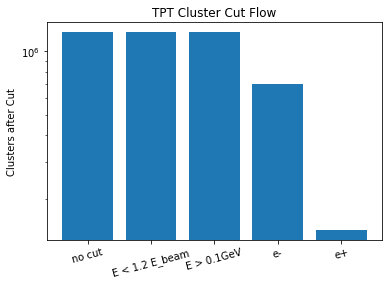

In [81]:
plt.bar(['no cut', 'E < 1.2 E_beam', 'E > 0.1GeV', 'e-', 'e+'],
        f['cluster_selection_cutflow'].values())
plt.xticks(rotation = 15)
plt.yscale('log')
plt.ylabel('Clusters after Cut')
plt.title('TPT Cluster Cut Flow')
plt.show()

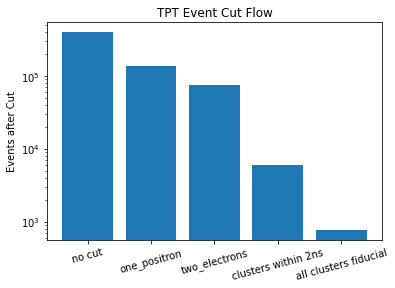

In [5]:
plt.bar(['no cut', 'one_positron','two_electrons','clusters within 2ns','all clusters fiducial'],
        f['event_selection_cutflow'].values())
plt.xticks(rotation = 15)
plt.yscale('log')
plt.title('TPT Event Cut Flow')
plt.ylabel('Events after Cut')
plt.show()

## Cluster Variables
During the last two cuts, we want to study how the cluster variables evolve. Below, we have various cluster variables and meta-variables plotted.

In [30]:
selections = ['pre_time_cut','pre_fiducial_cut','final_selection']
def follow_cuts(hist_name, xlabel) :
    fig, ax = plt.subplots()
    for name in selections :
        f[f'tpt_{name}_{hist_name}_h'].to_hist().plot(ax=ax,label=name)
    plt.legend()
    plt.ylabel('Event Count')
    plt.yscale('log')
    plt.xlabel(xlabel)
    plt.title('Three Prong Tridents : Run 007800 Partition 158')
    plt.show()
    
def follow_cuts_2d(hist_name, xlabel, ylabel, size = None) :
    fig, axl = plt.subplots(nrows=len(selections))
    if size is not None :
        fig.set_size_inches(*size)
    for name, ax in zip(selections,axl) :
        f[f'tpt_{name}_{hist_name}_hh'].to_hist().plot(ax=ax, cmin=1)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(name)
    fig.tight_layout()
    plt.suptitle('Three Prong Tridents : Run 007800 Partition 158', y = 1.01)
    plt.show()

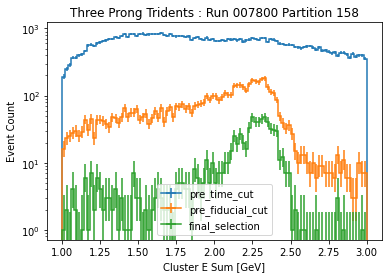

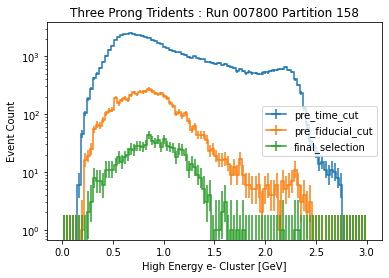

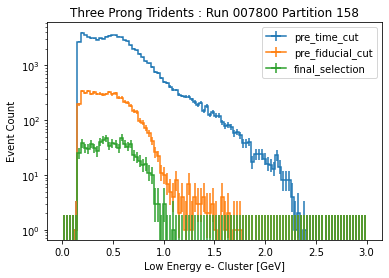

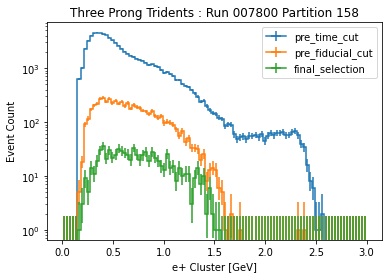

In [12]:
follow_cuts('cluster_E_sum','Cluster E Sum [GeV]')
follow_cuts('electron0_cluster_E', 'High Energy e- Cluster [GeV]')
follow_cuts('electron1_cluster_E', 'Low Energy e- Cluster [GeV]')
follow_cuts('positron_cluster_E', 'e+ Cluster [GeV]')

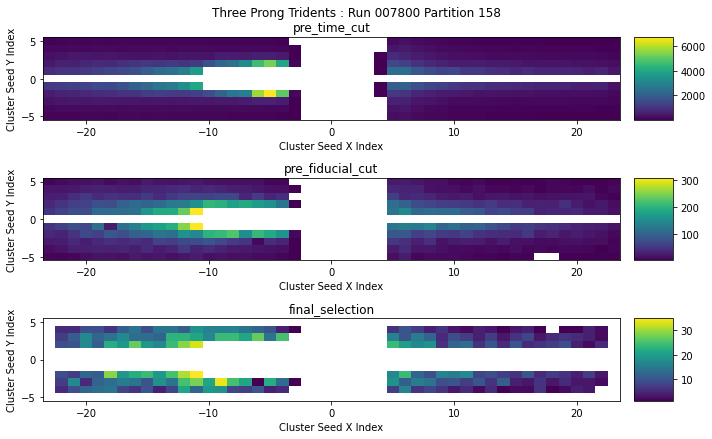

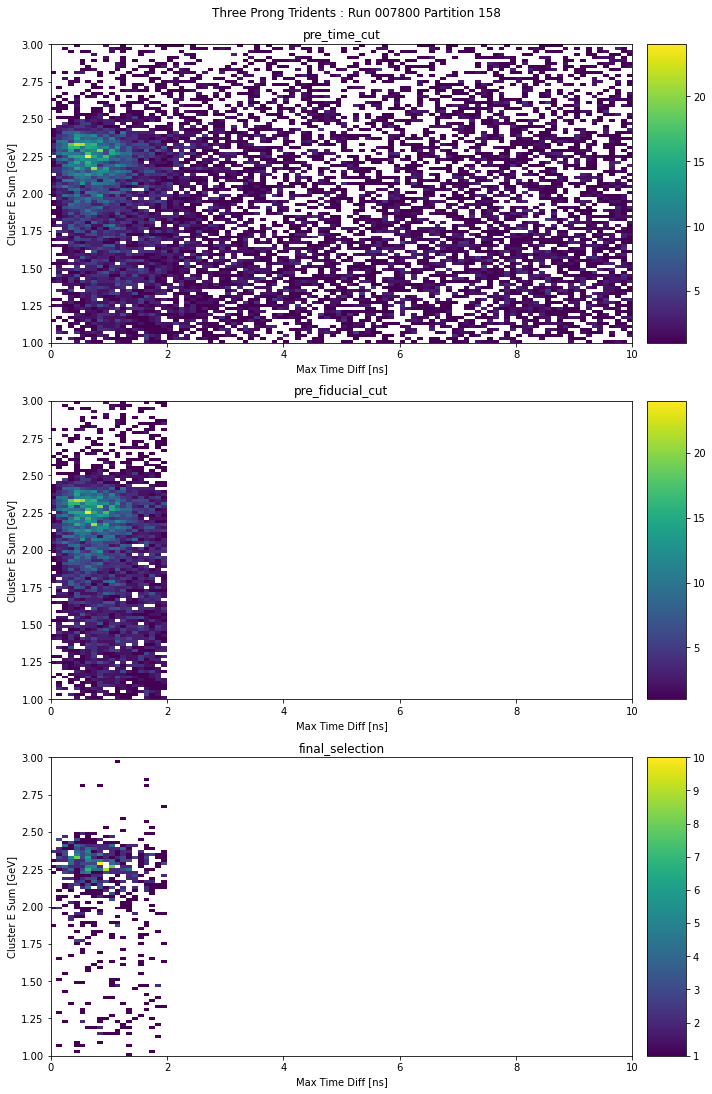

In [33]:
follow_cuts_2d('cluster_seed_pos','Cluster Seed X Index', 'Cluster Seed Y Index',size=(10,6))
follow_cuts_2d('max_time_diff_vs_E_sum','Max Time Diff [ns]', 'Cluster E Sum [GeV]', size=(10,15))